<a href="https://colab.research.google.com/github/harvard-ml-courses/a-cs281-demo/blob/master/04_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Gaussians

In [0]:
!pip install -qU plotly torch daft
!rm -fr start; git clone --single-branch -b demos2018 -q https://github.com/harvard-ml-courses/cs281-demos start; cp -f start/cs281.py cs281.py

tcmalloc: large alloc 1073750016 bytes == 0x59180000 @  0x7f83141ef1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
import torch
import torch.distributions as ds
from plotly.offline import iplot
import plotly.graph_objs as go
import cs281
import daft

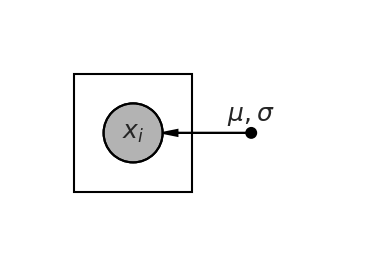

In [0]:
pgm = daft.PGM([3, 2])
pgm.add_node(daft.Node("x", "$x_i$", 1, 1, observed=True))
pgm.add_node(daft.Node("theta", r"$\mu,\sigma$", 2, 1, fixed=True))
pgm.add_edge("theta", "x")
pgm.add_plate(daft.Plate([0.5, 0.5, 1, 1], ""))
pgm.render()
pgm.figure.dpi=150

In [0]:
mean = -4.9 #@param {type:"slider", min:-10, max:10, step:0.1}
sigma = 2.8 #@param {type:"slider", min:0, max:10, step:0.1}
normal = ds.Normal(mean, sigma)
x = torch.linspace(-10, 10, 100)
data = [go.Scatter(x = x.numpy(),
                   y = normal.log_prob(x).exp().numpy())]
iplot(data)

## Linear-Gaussian

$$p(x) = {\cal N}(\mu_x, \Sigma_x)$$
$$p(y | x) = {\cal N}(Ax + b, \Sigma_{y})$$



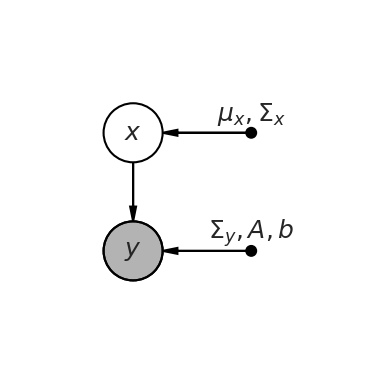

In [0]:
pgm = daft.PGM([3, 3])
pgm.add_node(daft.Node("y", "$y$", 1, 1, observed=True))
pgm.add_node(daft.Node("sigma", r"$\Sigma_y, A, b$", 2, 1, fixed=True))
pgm.add_node(daft.Node("hyper", r"$\mu_x, \Sigma_x$", 2, 2, fixed=True))
pgm.add_node(daft.Node("x", r"$x$", 1, 2))
pgm.add_edge("sigma", "y")
pgm.add_edge("hyper", "x")
pgm.add_edge("x", "y")
#pgm.add_plate(daft.Plate([0.5, 0.5, 1, 1], ""))
pgm.render()
pgm.figure.dpi=150

In [0]:
def sample(p_x, p_y_x, A, b):
    x = p_x.sample()
    y = p_y_x.sample(A @ x + b)
    return y


def linear_guassian(y, p_x, precision_y, A, b):
    precision_xy = p_x.precision_matrix \
        + A.transpose(0, 1) @ precision_y @ A 
    sigma_xy = precision_xy.inverse()
    mean_xy = sigma_xy @ \
        (A.transpose(0, 1) @ precision_y @ (y - b) \
         + p_x.precision_matrix @ p_x.mean)
    return ds.MultivariateNormal(mean_xy, sigma_xy)
    

## Bayesian

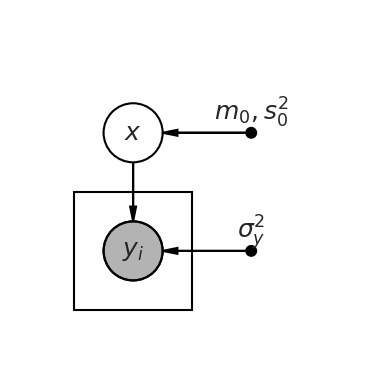

In [0]:
pgm = daft.PGM([3, 3])
pgm.add_node(daft.Node("y", "$y_i$", 1, 1, observed=True))
pgm.add_node(daft.Node("sigma", r"$\sigma^2_y$", 2, 1, fixed=True))
pgm.add_node(daft.Node("hyper", r"$m_0, s^2_0$", 2, 2, fixed=True))
pgm.add_node(daft.Node("x", r"$x$", 1, 2))
pgm.add_edge("sigma", "y")
pgm.add_edge("hyper", "x")
pgm.add_edge("x", "y")
pgm.add_plate(daft.Plate([0.5, 0.5, 1, 1], ""))
pgm.render()
pgm.figure.dpi=150

Key Idea: Univariate-Gaussian plates become Multivariate with diagonal covariance ($\Sigma_y$)

In [0]:
#y = obs
#sigma_y = torch.zeros(obs.shape[0], obs.shape[0])
#sigma_y.diag(sigma_y)
#A = torch.ones(1, obs.shape[0])
#b = torch.zeros(obs.shape[0])
#p_y_x = ds.Normal(obs, A)
#p_x = ds.Normal(m_0, S_0)


In [0]:
x_range = torch.linspace(-10, 10, 50) 
y_range = torch.linspace(-10, 10, 50)
zs = torch.tensor([ [ [x, y] for x in x_range] for y in y_range])
def plot(prior, posterior, obs):
    z = posterior.log_prob(zs).exp()
    z2 = prior.log_prob(zs).exp()
    z3 = (zs - obs).pow(2).sum(-1) < 0.2
    surfaces = [go.Surface(z = z.numpy(),  x=x_range.numpy(), y=y_range.numpy(),
                           name="Posterior Predictive", showscale=False, colorscale="Blues"),
                go.Surface(z = z2.numpy(), x=x_range.numpy(), y=y_range.numpy(),
                           name="Posterior Predictive", showscale=False, colorscale="Greys"),
                go.Surface(z = z3.numpy(), x=x_range.numpy(), y=y_range.numpy(),
                           name="Posterior Predictive", showscale=False, colorscale="Reds"),
               ]

    layout = go.Layout(
        title='Prior vs Posterior vs Observations',
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
            ))
    fig = go.Figure(data=surfaces, layout=layout)
    iplot(fig)

In [0]:
#@title Prior { run: "auto" }
ybar_1 = -9 #@param {type:"slider", min:-10, max:10, step:1}
ybar_2 = 2 #@param {type:"slider", min:-10, max:10, step:1}
N = 2 #@param {type:"slider", min:0, max:100, step:1}
precision = 0.5 #@param {type:"slider", min:0, max:5, step:0.1}
prior_precision = 3.5 #@param {type:"slider", min:0, max:5, step:0.1}
p_x = ds.MultivariateNormal(torch.zeros(2), (1. / prior_precision) * torch.eye(2))
obs = torch.tensor([ybar_1, ybar_2]).float()
p_x_y = linear_guassian(obs, 
                        p_x, N*torch.diag(precision * torch.ones(2)),
                torch.eye(2), torch.zeros(2))
plot(p_x, p_x_y, obs)

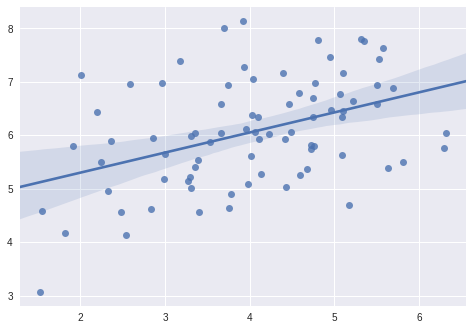

In [0]:
import seaborn as sns
import torch
import torch.distributions as ds
mean, cov = torch.tensor([4, 6.]), torch.tensor([(1.5, .7), (.7, 1)])
xy = ds.MultivariateNormal(mean, cov).sample(torch.Size([80]))

# Regplot shows a regression plot with variances
ax = sns.regplot(x=xy[:,0].numpy(),
                 y=xy[:,1].numpy())